In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils import data

<br><br><br><br>
# Required input

In [3]:
vol = "Masaya"
num_input_scenes = 10
train_percent = 0.65

<br><br><br><br>

# Basic data import

In [4]:
numpy_data_location = "data/" + vol + "/numpy_data_cube.npy"
table_data_location = "data/" + vol + "/good_df.csv"

In [5]:
volcano_scenes = np.load(numpy_data_location)
tabular_metadata = pd.read_csv(table_data_location)

print(volcano_scenes.shape)
tabular_metadata.head()

(68, 5, 96, 96)


,Unnamed: 0,X,nighttime_volcano_files,quality,dates,color,T_above_back
0,23,23,processed/AST_L1T_00301202001042034_2017080801...,y,2001-01-20,black,3.623644
1,85,85,processed/AST_L1T_00304032001041259_2017080723...,u,2001-04-03,red,2.921605
2,6,6,processed/AST_L1T_00301072002041121_2017080713...,y,2002-01-07,black,4.707373
3,226,226,processed/AST_L1T_00311162002040330_2017071700...,u,2002-11-16,red,4.619711
4,10,10,processed/AST_L1T_00301102003040931_2017071708...,y,2003-01-10,black,6.102586


<br><br><br><br>
# Separate model inputs (previous $n$ scenes, time differences) and outputs (subsequent scene)

In [6]:
# Array for the prior scenes
x_scenes = np.zeros([len(volcano_scenes) - num_input_scenes,
                     num_input_scenes,
                     volcano_scenes.shape[1],
                     volcano_scenes.shape[2],
                     volcano_scenes.shape[3]])
# Array for the target scenes
y_scenes = np.zeros([len(volcano_scenes) - num_input_scenes,
                     1,
                     volcano_scenes.shape[1],
                     volcano_scenes.shape[2],
                     volcano_scenes.shape[3]])


# Array for the prior max temperature above the background
x_temperatures = np.zeros([len(volcano_scenes) - num_input_scenes,
                   num_input_scenes])
# Array for the target max temperature above the background
y_temperatures = np.zeros([len(volcano_scenes) - num_input_scenes])


# Formatting the string dates as datetime objects
formatted_dates = [datetime.strptime(date, '%Y-%m-%d') for date in tabular_metadata['dates']]
# Array for the differences between dates of image acquisition
time_differences = np.zeros_like(x_temperatures)


# For all observations - acknowledging that the first (n-1) wont have n prior observations
for i in range(num_input_scenes, len(volcano_scenes)):
    # Store the image data
    x_scenes[i - num_input_scenes, :, :, :, :] = volcano_scenes[(i - num_input_scenes):i, :, :, :]
    y_scenes[i - num_input_scenes, 0, :, :, :] = volcano_scenes[i, :, :, :]
    # Store the max temperature scalars
    x_temperatures[i - num_input_scenes, :] = tabular_metadata['T_above_back'].values[(i - num_input_scenes):i]
    y_temperatures[i - num_input_scenes] = tabular_metadata['T_above_back'].values[i]
    # Compute the time differences and store
    dates_i_plus_1 = formatted_dates[(i - num_input_scenes + 1):(i + 1)]
    dates_i = formatted_dates[(i - num_input_scenes):i]
    for j in range(len(dates_i_plus_1)):
        time_differences[i - num_input_scenes, j] = (dates_i_plus_1[j] - dates_i[j]).days

In [10]:
x_scenes.shape, y_scenes.shape, time_differences.shape

((58, 10, 5, 96, 96), (58, 1, 5, 96, 96), (58, 10))

# Display a sample of the data gathered above

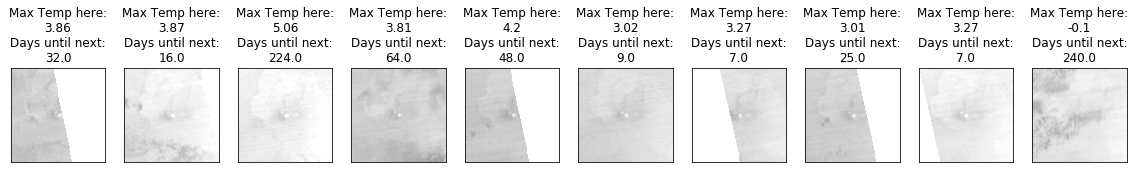

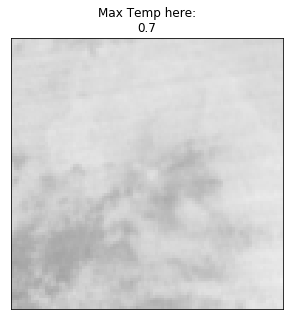

In [6]:
# Gather a random index
random_index = np.random.choice(len(volcano_scenes) - num_input_scenes)

# Plot the previous observations in a short row
f, axarr = plt.subplots(1, num_input_scenes)
f.set_figheight(4)
f.set_figwidth(20)

# Gather color histogram values for color scaling
vmin, vmax = np.nanquantile(x_scenes, [0.01, 0.99])

# Plot all the previous observations
for i in range(num_input_scenes):
    axarr[i].imshow(x_scenes[random_index, i, 2, :, :], cmap = 'gist_gray',
                    vmin = vmin, vmax = vmax)
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title('Max Temp here:\n' + str(np.around(x_temperatures[random_index, i], decimals = 2)) +
                       '\nDays until next:\n' + str(np.around(time_differences[random_index, i], decimals = 0)))

# Plot the target observation
plt.figure(figsize = (5, 5))
plt.imshow(y_scenes[random_index, 0, 2, :, :],
           cmap = 'gist_gray',
           vmin = vmin, vmax = vmax)
plt.title('Max Temp here:\n' + str(np.around(y_temperatures[random_index], decimals = 2)))
plt.xticks([]); plt.yticks([]);